In [102]:
import pandas as pd
import numpy as np
import pylev
import umap
import Levenshtein
import random
import seaborn as sns
import jellyfish as jf
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE
from sklearn import cluster
from sklearn.preprocessing import normalize

In [2]:
templates_check = pd.read_csv("Templates/input_template_TRA-TRB.tsv", sep='\t')
display(templates_check)
templates_check = pd.read_csv("Templates/thimble_input_example_TRA-TRB.tsv", sep='\t')
display(templates_check)


,TCR_name,TRAV,TRAJ,TRA_CDR3,TRBV,TRBJ,TRB_CDR3,TRAC,TRBC,TRA_leader,TRB_leader,Linker,Link_order,TRA_5_prime_seq,TRA_3_prime_seq,TRB_5_prime_seq,TRB_3_prime_seq


,TCR_name,TRAV,TRAJ,TRA_CDR3,TRBV,TRBJ,TRB_CDR3,TRAC,TRBC,TRA_leader,TRB_leader,Linker,Link_order,TRA_5_prime_seq,TRA_3_prime_seq,TRB_5_prime_seq,TRB_3_prime_seq
0,C25,TRAV26-2,TRAJ43,CILDNNNDMRF,TRBV7-6,TRBJ1-4,CASSLAPGTTNEKLFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C25-alpha,TRAV26-2,TRAJ43,CILDNNNDMRF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C25-beta,NaN,NaN,NaN,TRBV7-6,TRBJ1-4,CASSLAPGTTNEKLFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C25-linked_ab,TRAV26-2,TRAJ43,CILDNNNDMRF,TRBV7-6,TRBJ1-4,CASSLAPGTTNEKLFF,NaN,NaN,NaN,NaN,P2A,AB,NaN,NaN,NaN,NaN
4,C25-linked_ba,TRAV26-2,TRAJ43,CILDNNNDMRF,TRBV7-6,TRBJ1-4,CASSLAPGTTNEKLFF,NaN,NaN,NaN,NaN,P2A,BA,NaN,NaN,NaN,NaN
5,C25-linked_ba_kozak_stop,TRAV26-2,TRAJ43,CILDNNNDMRF,TRBV7-6,TRBJ1-4,CASSLAPGTTNEKLFF,NaN,NaN,NaN,NaN,P2A,NaN,NaN,TAA,CCGCCACC,NaN


In [34]:
# read VDJdb full dataset
VDJdb_full = pd.read_csv("Jupyter VDJdb data/vdjdb_full.txt", sep = "\t", low_memory=False)
VDJdb_full = VDJdb_full.dropna(subset = ["cdr3.alpha", "cdr3.beta", "v.alpha", "v.beta"])
VDJdb_full = VDJdb_full[VDJdb_full["species"]=="HomoSapiens"]
VDJdb_full = VDJdb_full[VDJdb_full["vdjdb.score"]>0]
display(VDJdb_full)


# read VDJdb full dataset
VDJdb_total = pd.read_csv("Jupyter VDJdb data/vdjdb_to_tcrdist.csv", low_memory=False)
# VDJdb_full = VDJdb_full.dropna(subset = ["cdr3.alpha", "cdr3.beta", "v.alpha", "v.beta"])
# VDJdb_full = VDJdb_full[VDJdb_full["species"]=="HomoSapiens"]
# VDJdb_full = VDJdb_full[VDJdb_full["vdjdb.score"]>0]
display(VDJdb_total)

,cdr3.alpha,v.alpha,j.alpha,cdr3.beta,v.beta,d.beta,j.beta,species,mhc.a,mhc.b,...,meta.replica.id,meta.clone.id,meta.epitope.id,meta.tissue,meta.donor.MHC,meta.donor.MHC.method,meta.structure.id,cdr3fix.alpha,cdr3fix.beta,vdjdb.score
0,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,...,NaN,NaN,NaN,PBMC,"HLA-A*02:01,HLA-A*24:02;HLA-B*08:01,HLA-B*5701...",NaN,NaN,"{""cdr3"": ""CIVRAPGRADMRF"", ""cdr3_old"": ""CIVRAPG...","{""cdr3"": ""CASSYLPGQGDHYSNQPQHF"", ""cdr3_old"": ""...",2
2,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,CASSFEPGQGFYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,...,NaN,NaN,NaN,PBMC,"HLA-A*02,HLA-A*24:02;HLA-B*08:01,HLA-B*15;HLA-...",NaN,NaN,"{""cdr3"": ""CAVPSGAGSYQLTF"", ""cdr3_old"": ""CAVPSG...","{""cdr3"": ""CASSFEPGQGFYSNQPQHF"", ""cdr3_old"": ""C...",2
3,CAVKASGSRLT,TRAV2*01,NaN,CASSYEPGQVSHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,...,NaN,NaN,NaN,PBMC,"HLA-A*01:01,HLA-A*02:01;HLA-B*08:01,HLA-B*57:0...",NaN,NaN,"{""cdr3"": ""CAVKASGSRLT"", ""cdr3_old"": ""CAVKASGSR...","{""cdr3"": ""CASSYEPGQVSHYSNQPQHF"", ""cdr3_old"": ""...",2
4,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,CASSALASLNEQFF,TRBV14*01,NaN,TRBJ2-1*01,HomoSapiens,HLA-B*08,B2M,...,NaN,NaN,NaN,PBMC,"HLA-A*01:01,HLA-A*02:01;HLA-B*08:01,HLA-B*57:0...",NaN,NaN,"{""cdr3"": ""CAYRPPGTYKYIF"", ""cdr3_old"": ""CAYRPPG...","{""cdr3"": ""CASSALASLNEQFF"", ""cdr3_old"": ""CASSAL...",2
5,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,...,NaN,NaN,NaN,TCL culture,"HLA-A*02:01,HLA-A*24:02;HLA-B*08:01,HLA-B*5701...",NaN,NaN,"{""cdr3"": ""CIVRAPGRADMRF"", ""cdr3_old"": ""CIVRAPG...","{""cdr3"": ""CASSYLPGQGDHYSNQPQHF"", ""cdr3_old"": ""...",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59805,CAFLNAGGTSYGKLTF,TRAV38-1*01,TRAJ52*01,CASSWNGLAGDEQFF,TRBV6-2*01,NaN,TRBJ2-1*01,HomoSapiens,HLA-A*24:01,B2M,...,NaN,NaN,S1208,PBMC,NaN,NaN,NaN,"{""cdr3"": ""CAFLNAGGTSYGKLTF"", ""cdr3_old"": ""CAFL...","{""cdr3"": ""CASSWNGLAGDEQFF"", ""cdr3_old"": ""CASSW...",1
59806,CAVYNQGGKLIF,TRAV8-1*01,TRAJ23*01,CASSALVAFSTDTQYF,TRBV6-4*01,NaN,TRBJ2-3*01,HomoSapiens,HLA-A*24:01,B2M,...,NaN,NaN,S1208,PBMC,NaN,NaN,NaN,"{""cdr3"": ""CAVYNQGGKLIF"", ""cdr3_old"": ""CAVYNQGG...","{""cdr3"": ""CASSALVAFSTDTQYF"", ""cdr3_old"": ""CASS...",1
59807,CAVRALYNFNKFYF,TRAV3*01,TRAJ21*01,CASSSLAGEVNEQFF,TRBV7-2*01,NaN,TRBJ2-1*01,HomoSapiens,HLA-A*24:01,B2M,...,NaN,NaN,S1208,PBMC,NaN,NaN,NaN,"{""cdr3"": ""CAVRALYNFNKFYF"", ""cdr3_old"": ""CAVRAL...","{""cdr3"": ""CASSSLAGEVNEQFF"", ""cdr3_old"": ""CASSS...",1
59808,CAVESYNTDKLIF,TRAV41*01,TRAJ34*01,CASSSYTQRGLDYTGELFF,TRBV27*01,NaN,TRBJ2-2*01,HomoSapiens,HLA-A*24:01,B2M,...,NaN,NaN,S1208,PBMC,NaN,NaN,NaN,"{""cdr3"": ""CAVESYNTDKLIF"", ""cdr3_old"": ""CAVESYN...","{""cdr3"": ""CASSSYTQRGLDYTGELFF"", ""cdr3_old"": ""C...",1


,Unnamed: 0,id,cell_type,species,epitope_aa,epitope,epitope_species,subject,mhc_a_a,mhc_a_b,...,mhc_b_b,cdr3_a_aa,v_a_gene,j_a_gene,cdr3_b_aa,v_b_gene,j_b_gene,score,frequency,count
0,0,1,CD8+,HomoSapiens,FLKEKGGL,NaN,HIV-1,005,HLA-B*08,B2M,...,B2M,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,2,NaN,1
1,1,2,CD8+,HomoSapiens,FLKEKGGL,NaN,HIV-1,200,HLA-B*08,B2M,...,B2M,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,2,NaN,1
2,3,4,CD8+,HomoSapiens,FLKEKGGL,NaN,HIV-1,046,HLA-B*08,B2M,...,B2M,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,2,NaN,1
3,4,5,CD8+,HomoSapiens,FLKEQGGL,NaN,HIV-1,005,HLA-B*08,B2M,...,B2M,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,2,NaN,1
4,5,6,CD8+,HomoSapiens,FLKEQGGL,NaN,HIV-1,200,HLA-B*08,B2M,...,B2M,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,2,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,1761,29262,CD8+,HomoSapiens,QYIKWPWYI,S1208,SARS-CoV-2,CP46,HLA-A*24:01,B2M,...,B2M,CAFLNAGGTSYGKLTF,TRAV38-1*01,TRAJ52*01,CASSWNGLAGDEQFF,TRBV6-2*01,TRBJ2-1*01,1,1/11,1
1601,1762,29263,CD8+,HomoSapiens,QYIKWPWYI,S1208,SARS-CoV-2,CP46,HLA-A*24:01,B2M,...,B2M,CAVYNQGGKLIF,TRAV8-1*01,TRAJ23*01,CASSALVAFSTDTQYF,TRBV6-4*01,TRBJ2-3*01,1,1/11,1
1602,1763,29264,CD8+,HomoSapiens,QYIKWPWYI,S1208,SARS-CoV-2,CP46,HLA-A*24:01,B2M,...,B2M,CAVRALYNFNKFYF,TRAV3*01,TRAJ21*01,CASSSLAGEVNEQFF,TRBV7-2*01,TRBJ2-1*01,1,1/11,1
1603,1764,29265,CD8+,HomoSapiens,QYIKWPWYI,S1208,SARS-CoV-2,CP46,HLA-A*24:01,B2M,...,B2M,CAVESYNTDKLIF,TRAV41*01,TRAJ34*01,CASSSYTQRGLDYTGELFF,TRBV27*01,TRBJ2-2*01,1,1/11,1


In [36]:
# vdj_useful_db = VDJdb_full[["epitope_species", "v.alpha", "j.alpha", "cdr3.alpha", 
#                             "v.beta", "j.beta",  "cdr3.beta"]]

# vdj_useful_db[["TRAC", "TRBC", "TRA_leader", 
#               "TRB_leader", "Linker", "Link_order", 
#               "TRA_5_prime_seq", "TRA_3_prime_seq", "TRB_5_prime_seq", "TRB_3_prime_seq"]] = np.nan
# display(vdj_useful_db)

# VDJdb_Stitchr = vdj_useful_db.rename(columns = {'species': 'TCR_name', 'cdr3.alpha': 'TRA_CDR3', 
#                                                 'v.alpha': 'TRAV', 'j.alpha':'TRAJ', 'cdr3.beta': 'TRB_CDR3', 
#                                                 'v.beta':'TRBV', 'j.beta':'TRBJ'})
# display(VDJdb_Stitchr)

vdj_useful_db = VDJdb_total[["epitope_species", "v_a_gene", "j_a_gene", "cdr3_a_aa", 
                            "v_b_gene", "j_b_gene",  "cdr3_b_aa"]]

vdj_useful_db[["TRAC", "TRBC", "TRA_leader", 
              "TRB_leader", "Linker", "Link_order", 
              "TRA_5_prime_seq", "TRA_3_prime_seq", "TRB_5_prime_seq", "TRB_3_prime_seq"]] = np.nan
display(vdj_useful_db)

VDJdb_Stitchr = vdj_useful_db.rename(columns = {'epitope_species': 'TCR_name', 'cdr3_a_aa': 'TRA_CDR3', 
                                                'v_a_gene': 'TRAV', 'j_a_gene':'TRAJ', 'cdr3_b_aa': 'TRB_CDR3', 
                                                'v_b_gene':'TRBV', 'j_b_gene':'TRBJ'})
display(VDJdb_Stitchr)


<ipython-input-36-9274782da28a>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vdj_useful_db[["TRAC", "TRBC", "TRA_leader",
D:\Anaconda Python\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,epitope_species,v_a_gene,j_a_gene,cdr3_a_aa,v_b_gene,j_b_gene,cdr3_b_aa,TRAC,TRBC,TRA_leader,TRB_leader,Linker,Link_order,TRA_5_prime_seq,TRA_3_prime_seq,TRB_5_prime_seq,TRB_3_prime_seq
0,HIV-1,TRAV26-1*01,TRAJ43*01,CIVRAPGRADMRF,TRBV13*01,TRBJ1-5*01,CASSYLPGQGDHYSNQPQHF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HIV-1,TRAV20*01,TRAJ28*01,CAVPSGAGSYQLTF,TRBV13*01,TRBJ1-5*01,CASSFEPGQGFYSNQPQHF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HIV-1,TRAV38-2/DV8*01,TRAJ40*01,CAYRPPGTYKYIF,TRBV14*01,TRBJ2-1*01,CASSALASLNEQFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HIV-1,TRAV26-1*01,TRAJ43*01,CIVRAPGRADMRF,TRBV13*01,TRBJ1-5*01,CASSYLPGQGDHYSNQPQHF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HIV-1,TRAV20*01,TRAJ28*01,CAVPSGAGSYQLTF,TRBV13*01,TRBJ1-5*01,CASSFEPGQGFYSNQPQHF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,SARS-CoV-2,TRAV38-1*01,TRAJ52*01,CAFLNAGGTSYGKLTF,TRBV6-2*01,TRBJ2-1*01,CASSWNGLAGDEQFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1601,SARS-CoV-2,TRAV8-1*01,TRAJ23*01,CAVYNQGGKLIF,TRBV6-4*01,TRBJ2-3*01,CASSALVAFSTDTQYF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1602,SARS-CoV-2,TRAV3*01,TRAJ21*01,CAVRALYNFNKFYF,TRBV7-2*01,TRBJ2-1*01,CASSSLAGEVNEQFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1603,SARS-CoV-2,TRAV41*01,TRAJ34*01,CAVESYNTDKLIF,TRBV27*01,TRBJ2-2*01,CASSSYTQRGLDYTGELFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,TCR_name,TRAV,TRAJ,TRA_CDR3,TRBV,TRBJ,TRB_CDR3,TRAC,TRBC,TRA_leader,TRB_leader,Linker,Link_order,TRA_5_prime_seq,TRA_3_prime_seq,TRB_5_prime_seq,TRB_3_prime_seq
0,HIV-1,TRAV26-1*01,TRAJ43*01,CIVRAPGRADMRF,TRBV13*01,TRBJ1-5*01,CASSYLPGQGDHYSNQPQHF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HIV-1,TRAV20*01,TRAJ28*01,CAVPSGAGSYQLTF,TRBV13*01,TRBJ1-5*01,CASSFEPGQGFYSNQPQHF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HIV-1,TRAV38-2/DV8*01,TRAJ40*01,CAYRPPGTYKYIF,TRBV14*01,TRBJ2-1*01,CASSALASLNEQFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HIV-1,TRAV26-1*01,TRAJ43*01,CIVRAPGRADMRF,TRBV13*01,TRBJ1-5*01,CASSYLPGQGDHYSNQPQHF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HIV-1,TRAV20*01,TRAJ28*01,CAVPSGAGSYQLTF,TRBV13*01,TRBJ1-5*01,CASSFEPGQGFYSNQPQHF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,SARS-CoV-2,TRAV38-1*01,TRAJ52*01,CAFLNAGGTSYGKLTF,TRBV6-2*01,TRBJ2-1*01,CASSWNGLAGDEQFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1601,SARS-CoV-2,TRAV8-1*01,TRAJ23*01,CAVYNQGGKLIF,TRBV6-4*01,TRBJ2-3*01,CASSALVAFSTDTQYF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1602,SARS-CoV-2,TRAV3*01,TRAJ21*01,CAVRALYNFNKFYF,TRBV7-2*01,TRBJ2-1*01,CASSSLAGEVNEQFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1603,SARS-CoV-2,TRAV41*01,TRAJ34*01,CAVESYNTDKLIF,TRBV27*01,TRBJ2-2*01,CASSSYTQRGLDYTGELFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
VDJdb_Stitchr.to_csv("Scripts/TRA_TRB_Stitchr.tsv", index=False, sep = '\t')

In [38]:
test = pd.read_csv("Scripts/TRA_TRB_Stitchr.tsv", sep='\t')
display(test)
templates_check = pd.read_csv("Templates/thimble_input_example_TRA-TRB.tsv", sep='\t')
display(templates_check)


,TCR_name,TRAV,TRAJ,TRA_CDR3,TRBV,TRBJ,TRB_CDR3,TRAC,TRBC,TRA_leader,TRB_leader,Linker,Link_order,TRA_5_prime_seq,TRA_3_prime_seq,TRB_5_prime_seq,TRB_3_prime_seq
0,HIV-1,TRAV26-1*01,TRAJ43*01,CIVRAPGRADMRF,TRBV13*01,TRBJ1-5*01,CASSYLPGQGDHYSNQPQHF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HIV-1,TRAV20*01,TRAJ28*01,CAVPSGAGSYQLTF,TRBV13*01,TRBJ1-5*01,CASSFEPGQGFYSNQPQHF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HIV-1,TRAV38-2/DV8*01,TRAJ40*01,CAYRPPGTYKYIF,TRBV14*01,TRBJ2-1*01,CASSALASLNEQFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HIV-1,TRAV26-1*01,TRAJ43*01,CIVRAPGRADMRF,TRBV13*01,TRBJ1-5*01,CASSYLPGQGDHYSNQPQHF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HIV-1,TRAV20*01,TRAJ28*01,CAVPSGAGSYQLTF,TRBV13*01,TRBJ1-5*01,CASSFEPGQGFYSNQPQHF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,SARS-CoV-2,TRAV38-1*01,TRAJ52*01,CAFLNAGGTSYGKLTF,TRBV6-2*01,TRBJ2-1*01,CASSWNGLAGDEQFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1601,SARS-CoV-2,TRAV8-1*01,TRAJ23*01,CAVYNQGGKLIF,TRBV6-4*01,TRBJ2-3*01,CASSALVAFSTDTQYF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1602,SARS-CoV-2,TRAV3*01,TRAJ21*01,CAVRALYNFNKFYF,TRBV7-2*01,TRBJ2-1*01,CASSSLAGEVNEQFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1603,SARS-CoV-2,TRAV41*01,TRAJ34*01,CAVESYNTDKLIF,TRBV27*01,TRBJ2-2*01,CASSSYTQRGLDYTGELFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,TCR_name,TRAV,TRAJ,TRA_CDR3,TRBV,TRBJ,TRB_CDR3,TRAC,TRBC,TRA_leader,TRB_leader,Linker,Link_order,TRA_5_prime_seq,TRA_3_prime_seq,TRB_5_prime_seq,TRB_3_prime_seq
0,C25,TRAV26-2,TRAJ43,CILDNNNDMRF,TRBV7-6,TRBJ1-4,CASSLAPGTTNEKLFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C25-alpha,TRAV26-2,TRAJ43,CILDNNNDMRF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C25-beta,NaN,NaN,NaN,TRBV7-6,TRBJ1-4,CASSLAPGTTNEKLFF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C25-linked_ab,TRAV26-2,TRAJ43,CILDNNNDMRF,TRBV7-6,TRBJ1-4,CASSLAPGTTNEKLFF,NaN,NaN,NaN,NaN,P2A,AB,NaN,NaN,NaN,NaN
4,C25-linked_ba,TRAV26-2,TRAJ43,CILDNNNDMRF,TRBV7-6,TRBJ1-4,CASSLAPGTTNEKLFF,NaN,NaN,NaN,NaN,P2A,BA,NaN,NaN,NaN,NaN
5,C25-linked_ba_kozak_stop,TRAV26-2,TRAJ43,CILDNNNDMRF,TRBV7-6,TRBJ1-4,CASSLAPGTTNEKLFF,NaN,NaN,NaN,NaN,P2A,NaN,NaN,TAA,CCGCCACC,NaN


In [39]:
TRA_TRB_Stitchr_aa = pd.read_csv("Scripts/TRA_TRB_Stitchr_aa.tsv", sep='\t')
display(TRA_TRB_Stitchr_aa)

,TCR_name,TRA_nt,TRB_nt,TRA_aa,TRB_aa,TRAV,TRAJ,TRA_CDR3,TRBV,TRBJ,...,TRB_leader,Linker,Link_order,TRA_5_prime_seq,TRA_3_prime_seq,TRB_5_prime_seq,TRB_3_prime_seq,Linked_nt,Linked_aa,Warnings/Errors
0,HIV-1,ATGAGGCTGGTGGCAAGAGTAACTGTGTTTCTGACCTTTGGAACTA...,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,MRLVARVTVFLTFGTIIDAKTTQPPSMDCAEGRAANLPCNHSTISG...,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,TRAV26-1*01,TRAJ43*01,CIVRAPGRADMRF,TRBV13*01,TRBJ1-5*01,...,TRBV13*01(L),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[None]
1,HIV-1,ATGGAGAAAATGTTGGAGTGTGCATTCATAGTCTTGTGGCTTCAGC...,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,MEKMLECAFIVLWLQLGWLSGEDQVTQSPEALRLQEGESSSLNCSY...,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,TRAV20*01,TRAJ28*01,CAVPSGAGSYQLTF,TRBV13*01,TRBJ1-5*01,...,TRBV13*01(L),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[None]
2,HIV-1,ATGGCATGCCCTGGCTTCCTGTGGGCACTTGTGATCTCCACCTGTC...,ATGGTTTCCAGGCTTCTCAGTTTAGTGTCCCTTTGTCTCCTGGGAG...,MACPGFLWALVISTCLEFSMAQTVTQSQPEMSVQEAETVTLSCTYD...,MVSRLLSLVSLCLLGAKHIEAGVTQFPSHSVIEKGQTVTLRCDPIS...,TRAV38-2/DV8*01,TRAJ40*01,CAYRPPGTYKYIF,TRBV14*01,TRBJ2-1*01,...,TRBV14*01(L),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[None]
3,HIV-1,ATGAGGCTGGTGGCAAGAGTAACTGTGTTTCTGACCTTTGGAACTA...,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,MRLVARVTVFLTFGTIIDAKTTQPPSMDCAEGRAANLPCNHSTISG...,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,TRAV26-1*01,TRAJ43*01,CIVRAPGRADMRF,TRBV13*01,TRBJ1-5*01,...,TRBV13*01(L),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[None]
4,HIV-1,ATGGAGAAAATGTTGGAGTGTGCATTCATAGTCTTGTGGCTTCAGC...,ATGCTTAGTCCTGACCTGCCTGACTCTGCCTGGAACACCAGGCTCC...,MEKMLECAFIVLWLQLGWLSGEDQVTQSPEALRLQEGESSSLNCSY...,MLSPDLPDSAWNTRLLCHVMLCLLGAVSVAAGVIQSPRHLIKEKRE...,TRAV20*01,TRAJ28*01,CAVPSGAGSYQLTF,TRBV13*01,TRBJ1-5*01,...,TRBV13*01(L),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[None]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,SARS-CoV-2,ATGACACGAGTTAGCTTGCTGTGGGCAGTCGTGGTCTCCACCTGTC...,ATGAGCCTCGGGCTCCTGTGCTGTGGGGCCTTTTCTCTCCTGTGGG...,MTRVSLLWAVVVSTCLESGMAQTVTQSQPEMSVQEAETVTLSCTYD...,MSLGLLCCGAFSLLWAGPVNAGVTQTPKFRVLKTGQSMTLLCAQDM...,TRAV38-1*01,TRAJ52*01,CAFLNAGGTSYGKLTF,TRBV6-2*01,TRBJ2-1*01,...,TRBV6-2*01(L),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[None]
1601,SARS-CoV-2,ATGCTCCTGTTGCTCATACCAGTGCTGGGGATGATTTTTGCCCTGA...,ATGAGAATCAGGCTCCTGTGCTGTGTGGCCTTTTCTCTCCTGTGGG...,MLLLLIPVLGMIFALRDARAQSVSQHNHHVILSEAASLELGCNYSY...,MRIRLLCCVAFSLLWAGPVIAGITQAPTSQILAAGRRMTLRCTQDM...,TRAV8-1*01,TRAJ23*01,CAVYNQGGKLIF,TRBV6-4*01,TRBJ2-3*01,...,TRBV6-4*01(L),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[None]
1602,SARS-CoV-2,ATGGCCTCTGCACCCATCTCGATGCTTGCGATGCTCTTCACATTGA...,ATGGGCACCAGGCTCCTCTTCTGGGTGGCCTTCTGTCTCCTGGGGG...,MASAPISMLAMLFTLSGLRAQSVAQPEDQVNVAEGNPLTVKCTYSV...,MGTRLLFWVAFCLLGADHTGAGVSQSPSNKVTEKGKDVELRCDPIS...,TRAV3*01,TRAJ21*01,CAVRALYNFNKFYF,TRBV7-2*01,TRBJ2-1*01,...,TRBV7-2*01(L),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[None]
1603,SARS-CoV-2,ATGGTGAAGATCCGGCAATTTTTGTTGGCTATTTTGTGGCTTCAGC...,ATGGGCCCCCAGCTCCTTGGCTATGTGGTCCTTTGCCTTCTAGGAG...,MVKIRQFLLAILWLQLSCVSAAKNEVEQSPQNLTAQEGEFITINCS...,MGPQLLGYVVLCLLGAGPLEAQVTQNPRYLITVTGKKLTVTCSQNM...,TRAV41*01,TRAJ34*01,CAVESYNTDKLIF,TRBV27*01,TRBJ2-2*01,...,TRBV27*01(L),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[None]


In [40]:
TRA_nt = TRA_TRB_Stitchr_aa["TRA_nt"].dropna().tolist()

TRA_aa_dist = np.ones([len(TRA_nt), len(TRA_nt)])
for i, nt1 in enumerate(TRA_nt):
    for j, nt2 in enumerate(TRA_nt):
        TRA_aa_one_dist = Levenshtein.distance(nt1, nt2)
        TRA_aa_dist[i, j] = TRA_aa_one_dist
print(TRA_aa_dist)

0
[[  0. 187. 170. ... 179. 187. 178.]
 [187.   0. 187. ... 193. 152. 191.]
 [170. 187.   0. ... 180. 180. 141.]
 ...
 [179. 193. 180. ...   0. 190. 183.]
 [187. 152. 180. ... 190.   0. 192.]
 [178. 191. 141. ... 183. 192.   0.]]


In [104]:
# Normolize the distance matrix
TRA_aa_dist = normalize(TRA_aa_dist, axis=1, norm='l1')

In [99]:
TRB_nt = TRA_TRB_Stitchr_aa["TRB_nt"].dropna().tolist()

TRB_aa_dist = np.ones([len(TRB_nt), len(TRB_nt)])
for i, nt1 in enumerate(TRB_nt):
    for j, nt2 in enumerate(TRB_nt):
        TRB_aa_one_dist = Levenshtein.distance(nt1, nt2)
        TRB_aa_dist[i, j] = TRB_aa_one_dist
print(TRB_aa_dist)

[[  0.   8. 208. ... 208. 226. 215.]
 [  8.   0. 205. ... 208. 227. 213.]
 [208. 205.   0. ... 119. 186. 168.]
 ...
 [208. 208. 119. ...   0. 176. 159.]
 [226. 227. 186. ... 176.   0. 178.]
 [215. 213. 168. ... 159. 178.   0.]]


In [105]:
TRB_aa_dist = normalize(TRB_aa_dist, axis=1, norm='l1')

In [46]:
def draw_scatter(epitope, UMAP_fit, label):
    class_list = np.unique(epitope)
    n_class = len(class_list)
    palette = sns.hls_palette(n_colors=n_class) 
    plt.figure(figsize=(8, 8))
    
    for idx, species in enumerate(class_list):  
        color = palette[idx]
        indices = np.where(epitope == species)
        plt.scatter(UMAP_fit[indices, 0], UMAP_fit[indices, 1], color=color, label=label.iloc[species,0], s=30)  # , s=150
    plt.legend(fontsize=10, markerscale=1, bbox_to_anchor=(1, 1))
    
    
def label_gen(data):
    VDJ_test = data
    epitope = VDJ_test['TCR_name']
    epitope = pd.Categorical(epitope).codes
    spec_label_rep = pd.DataFrame({"antitope":data['TCR_name'], "label":epitope})
    spec_label = spec_label_rep.drop_duplicates(keep='first')
    spec_label = spec_label.sort_values("label")
    #display(TRA_spec_label)
    return spec_label, epitope

In [106]:
TRA_umap = umap.UMAP(random_state=42, n_components=2).fit_transform(TRA_aa_dist)

In [107]:
TRB_umap = umap.UMAP(random_state=42, n_components=2).fit_transform(TRB_aa_dist)

In [108]:
TRA_TSNE = TSNE(random_state=42, perplexity=10).fit_transform(TRA_aa_dist)

In [117]:
TRB_TSNE = TSNE(random_state=42, perplexity=10).fit_transform(TRB_aa_dist)

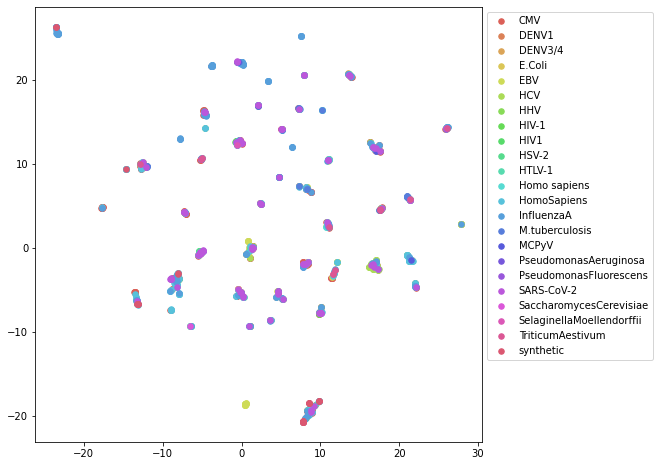

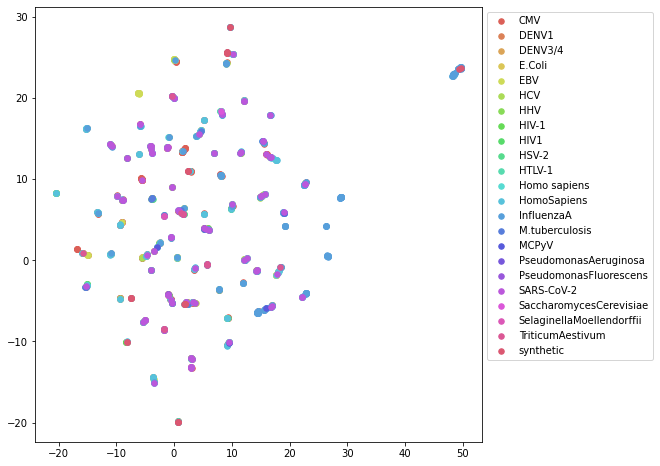

In [110]:
TRA_label, epitope = label_gen(TRA_TRB_Stitchr_aa)

draw_scatter(epitope, TRA_umap, TRA_label)
draw_scatter(epitope, TRB_umap, TRA_label)

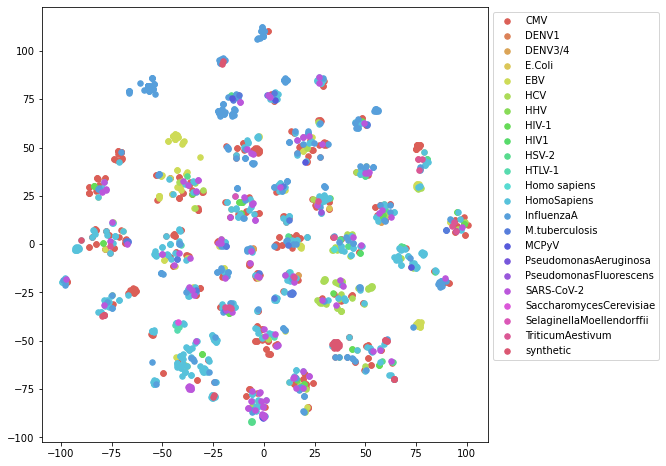

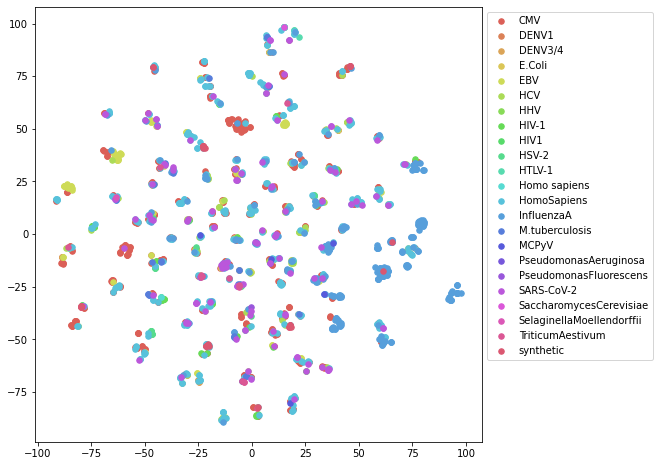

In [118]:
draw_scatter(epitope, TRA_TSNE, TRA_label)
draw_scatter(epitope, TRB_TSNE, TRA_label)

In [119]:
TRA_Kmeans_TSNE= cluster.KMeans(n_clusters = len(TRA_label), random_state = 42)
TRA_cluster_labels_TSNE = TRA_Kmeans_TSNE.fit_predict(TRA_TSNE)
print(TRA_cluster_labels_TSNE)

[18  0 19 ... 17  0  3]


D:\Anaconda Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Anaconda Python\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


In [120]:
TRB_Kmeans_TSNE= cluster.KMeans(n_clusters = len(TRA_label), random_state = 42)
TRB_cluster_labels_TSNE = TRB_Kmeans_TSNE.fit_predict(TRB_TSNE)
print(TRB_cluster_labels_TSNE)

[15 15 12 ...  2 14  5]


D:\Anaconda Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Anaconda Python\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


In [121]:
random.seed(10)
color_TRA = {}
for c in set(epitope):
    color_TRA[c] = '#' + hex(random.randint(16, 255))[2:4] + hex(random.randint(16, 255))[2:4] + hex(random.randint(16, 255))[2:4]

    color_TRB = {}
for c in set(epitope):
    color_TRB[c] = '#' + hex(random.randint(16, 255))[2:4] + hex(random.randint(16, 255))[2:4] + hex(random.randint(16, 255))[2:4]

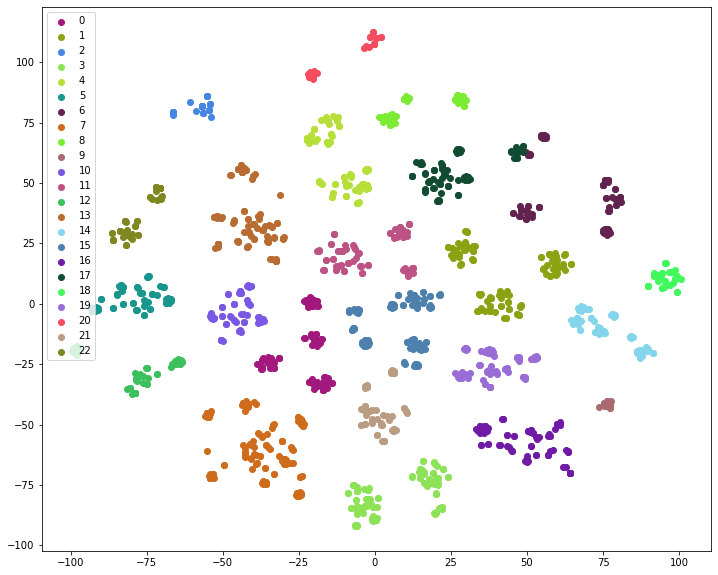

In [122]:
plt.figure(figsize=(12,10))
for label in set(TRA_cluster_labels_TSNE):
    plt.scatter(TRA_TSNE[TRA_cluster_labels_TSNE == label ,0], 
                TRA_TSNE[TRA_cluster_labels_TSNE == label,1], c=color_TRA[label], label=label)
plt.legend()
plt.show()

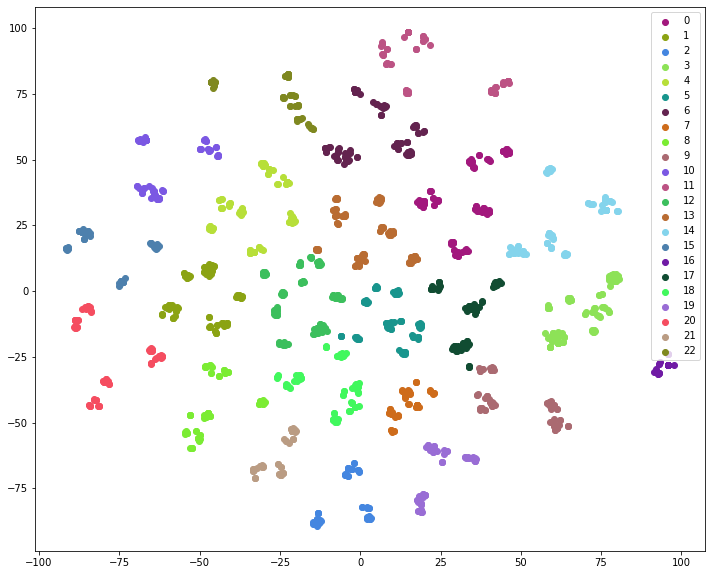

In [123]:
plt.figure(figsize=(12,10))
for label in set(TRB_cluster_labels_TSNE):
    plt.scatter(TRB_TSNE[TRB_cluster_labels_TSNE == label ,0], 
                TRB_TSNE[TRB_cluster_labels_TSNE == label,1], c=color_TRA[label], label=label)
plt.legend()
plt.show()